## 1. Importar librerías necesarias
Incluye librerías para manejo de archivos, procesamiento de texto, análisis de datos y embeddings.

## 1. Importar librerías necesarias
Incluye librerías para manejo de datos, procesamiento de texto y embeddings.

In [1]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Lectura y limpieza de datos
Se leen los archivos *_Merged.csv de cada carrera y se construye el corpus por carrera.

In [2]:
ruta_base = 'todas_las_plataformas'
columnas_texto = ['skills', 'description', 'description_final', 'initial_skills', 'EURACE_skills']
corpus_carreras = {}
for subcarpeta in os.listdir(ruta_base):
    ruta_subcarpeta = os.path.join(ruta_base, subcarpeta)
    archivo_objetivo = os.path.join(ruta_subcarpeta, f'{subcarpeta}_Merged.csv')
    if os.path.isfile(archivo_objetivo):
        try:
            df = pd.read_csv(archivo_objetivo, dtype=str)
        except Exception as e:
            print(f'Error leyendo {archivo_objetivo}: {e}')
            continue
        textos = []
        for col in columnas_texto:
            if col in df.columns:
                textos.extend(df[col].dropna().tolist())
        corpus_carreras[subcarpeta] = ' '.join(textos)
df_ejemplo = pd.DataFrame({'carrera': list(corpus_carreras.keys()), 'texto': list(corpus_carreras.values())})
df_ejemplo

,carrera,texto
0,Administración_de_Empresas,"Servicio al cliente, Ventas, Gestión de efecti..."
1,Agroindustria,Cualquier desviación debe comunicarse al super...
2,Ciencia_de_Datos,Más de 3 años de experiencia en desarrollo de ...
3,Computación,"En general, estamos buscando un miembro del eq..."
4,Economía,"Sobresalir, Inteligencia de negocios, Power Bi..."
5,Electricidad,2 anos de experiencia minima como montador (pr...
6,Electrónica_y_Automatización,El candidato ideal tendrá experiencia en trata...
7,Física,Licenciatura y mínimo 9 años de experiencia re...
8,Geología,Grado avanzado (maestría o doctorado) en geolo...
9,Ingeniería_Ambiental,"Una licenciatura en un campo científico, de in..."


## 3. Definición manual de habilidades técnicas (whitelist)
Se utiliza la misma whitelist definida manualmente en el análisis original.

In [3]:
# ... Copiar aquí la whitelist del cuaderno original ...
whitelist = {
    # Administración de Empresas
    'excel', 'power bi', 'erp', 'project management', 'sql', 'contabilidad', 'finanzas', 'marketing', 'gestión de recursos humanos', 'análisis financiero', 'auditoría', 'planificación estratégica', 'costos', 'presupuestos', 'negociación', 'comercio exterior', 'logística', 'supply chain', 'crm', 'ventas', 'administración de empresas',
    # Agroindustria
    'normas iso', 'producción', 'control de plagas', 'seguridad alimentaria', 'buenas prácticas agrícolas', 'procesamiento de alimentos', 'agronomía', 'fertilización', 'riego', 'manejo de cultivos', 'postcosecha', 'biotecnología', 'fitopatología', 'agroindustria', 'trazabilidad', 'certificación orgánica',
    # Ciencia de Datos
    'python', 'machine learning', 'data analysis', 'sql', 'r', 'big data', 'visualización de datos', 'estadística', 'deep learning', 'scikit-learn', 'pandas', 'numpy', 'matplotlib', 'data mining', 'análisis predictivo', 'regresión', 'clasificación', 'clustering', 'etl', 'modelado de datos', 'inteligencia artificial', 'análisis exploratorio', 'data science',
    # Computación
    'java', 'c++', 'python', 'linux', 'git', 'algoritmos', 'estructura de datos', 'sistemas operativos', 'redes', 'seguridad informática', 'programación orientada a objetos', 'desarrollo web', 'html', 'css', 'javascript', 'php', 'sql', 'c#', 'arquitectura de computadoras', 'compiladores', 'base de datos', 'ingeniería de software', 'testing', 'uml', 'scrum', 'devops',
    # Economía
    'econometría', 'estadística', 'finanzas', 'análisis de datos', 'excel', 'microeconomía', 'macroeconomía', 'modelos econométricos', 'análisis financiero', 'gestión de riesgos', 'mercados financieros', 'política económica', 'economía internacional', 'teoría de juegos', 'pronósticos', 'costos', 'presupuestos',
    # Electricidad
    'circuitos', 'electrónica', 'automatización', 'plc', 'motores eléctricos', 'instalaciones eléctricas', 'protecciones eléctricas', 'energía renovable', 'diseño eléctrico', 'subestaciones', 'mediciones eléctricas', 'generación eléctrica', 'distribución eléctrica', 'transformadores', 'sistemas eléctricos de potencia',
    # Electrónica y Automatización
    'plc', 'sensores', 'microcontroladores', 'automatización', 'circuitos', 'arduino', 'raspberry pi', 'robotica', 'sistemas embebidos', 'instrumentación', 'control automático', 'electrónica digital', 'electrónica analógica', 'scada', 'diseño de pcb', 'fpga', 'vhdl', 'proteus',
    # Física
    'simulación', 'matlab', 'python', 'análisis de datos', 'modelado', 'cálculo numérico', 'física computacional', 'teoría cuántica', 'óptica', 'mecánica clásica', 'termodinámica', 'electromagnetismo', 'análisis estadístico', 'instrumentación científica', 'latex',
    # Geología
    'gis', 'cartografía', 'sensores remotos', 'petrología', 'estratigrafía', 'geofísica', 'geotecnia', 'hidrogeología', 'mineralogía', 'mapeo geológico', 'análisis de suelos', 'modelado geológico', 'arcgis', 'qgis', 'geología estructural', 'geoquímica',
    # Ingeniería Ambiental
    'iso 14001', 'impacto ambiental', 'tratamiento de aguas', 'gis', 'normas ambientales', 'auditoría ambiental', 'gestión ambiental', 'residuos sólidos', 'remediación', 'evaluación ambiental', 'modelado ambiental', 'calidad de aire', 'sustentabilidad', 'legislación ambiental', 'educación ambiental',
    # Ingeniería Civil
    'autocad', 'sap2000', 'estructuras', 'topografía', 'cype', 'civil 3d', 'revit', 'diseño estructural', 'hormigón armado', 'cálculo estructural', 'gestión de obras', 'presupuestos', 'planificación de obras', 'geotecnia', 'hidráulica', 'vialidad', 'urbanismo',
    # Ingeniería de la Producción
    'lean manufacturing', 'six sigma', 'producción', 'erp', 'gestión de calidad', 'logística', 'supply chain', 'kaizen', 'just in time', 'mantenimiento industrial', 'planificación de la producción', 'optimización de procesos', 'simulación de procesos', 'costos industriales', 'mejora continua',
    # Ingeniería Química
    'reactores', 'procesos químicos', 'simulación', 'hysys', 'laboratorio', 'química analítica', 'balances de materia y energía', 'cromatografía', 'diseño de plantas', 'control de procesos', 'termodinámica química', 'ingeniería de procesos', 'análisis instrumental', 'química orgánica', 'química inorgánica',
    # Inteligencia Artificial
    'machine learning', 'deep learning', 'python', 'nlp', 'tensorflow', 'pytorch', 'redes neuronales', 'aprendizaje supervisado', 'aprendizaje no supervisado', 'procesamiento de lenguaje natural', 'scikit-learn', 'keras', 'inteligencia artificial', 'data mining',
    # Matemática
    'matlab', 'python', 'estadística', 'modelado', 'optimización', 'análisis numérico', 'ecuaciones diferenciales', 'probabilidad', 'teoría de números', 'álgebra lineal', 'cálculo', 'matemática aplicada', 'simulación',
    # Matemática Aplicada
    'matlab', 'python', 'estadística', 'simulación', 'optimización', 'análisis numérico', 'modelado matemático', 'ecuaciones diferenciales', 'cálculo', 'programación matemática',
    # Materiales
    'caracterización', 'microscopía', 'ensayos mecánicos', 'simulación', 'laboratorio', 'difracción de rayos x', 'metalografía', 'tratamientos térmicos', 'corrosión', 'análisis de materiales', 'propiedades mecánicas', 'microscopía electrónica',
    # Mecánica
    'solidworks', 'autocad', 'mecánica de materiales', 'catia', 'simulación', 'diseño mecánico', 'manufactura', 'elementos finitos', 'dinámica', 'termodinámica', 'cálculo estructural', 'prototipado', 'mantenimiento industrial',
    # Mecatrónica
    'plc', 'robotica', 'automatización', 'sensores', 'microcontroladores', 'sistemas embebidos', 'control automático', 'diseño mecánico', 'instrumentación', 'arduino', 'raspberry pi', 'vision artificial',
    # Petróleos
    'reservorios', 'perforación', 'simulación', 'petrel', 'ingeniería de yacimientos', 'geomecánica', 'ingeniería de perforación', 'producción petrolera', 'modelado de reservorios', 'petrofísica', 'ingeniería de producción',
    # Sistemas de Información
    'sql', 'erp', 'power bi', 'python', 'gestión de datos', 'business intelligence', 'data warehouse', 'etl', 'visualización de datos', 'base de datos', 'análisis de sistemas', 'sistemas de información',
    # Software
    'python', 'java', 'c++', 'git', 'javascript', 'typescript', 'html', 'css', 'react', 'node.js', 'desarrollo web', 'scrum', 'uml', 'testing', 'devops', 'docker', 'api', 'rest', 'c#', 'php',
    # Tecnologías de la Información
    'sql', 'cloud computing', 'python', 'linux', 'ciberseguridad', 'virtualización', 'redes', 'windows server', 'azure', 'aws', 'soporte técnico', 'seguridad informática', 'sistemas operativos', 'backup', 'firewall', 'vpn',
    # Telecomunicaciones
    'redes', 'cisco', 'fibra óptica', 'wireless', 'comunicaciones digitales', 'telefonía ip', 'microondas', 'radioenlaces', 'lte', 'routing', 'switching', 'voz sobre ip', 'protocolos de comunicación',
}
habilidades = sorted([h.lower() for h in whitelist])

## 4. Matriz término-documento (habilidad-carrera) ANTES de embeddings
Se construye la matriz de conteo de ocurrencias de cada habilidad en cada carrera, usando la whitelist.

In [4]:
carreras = list(corpus_carreras.keys())
corpus = [corpus_carreras[c].lower() for c in carreras]
vectorizer = CountVectorizer(vocabulary=habilidades, analyzer='word', ngram_range=(1, 5), lowercase=True)
X = vectorizer.fit_transform(corpus)
matriz_td = pd.DataFrame(X.T.toarray(), index=vectorizer.get_feature_names_out(), columns=carreras)
matriz_td.index.name = 'habilidad'
matriz_td.head(10)

,Administración_de_Empresas,Agroindustria,Ciencia_de_Datos,Computación,Economía,Electricidad,Electrónica_y_Automatización,Física,Geología,Ingeniería_Ambiental,...,Matemática,Matemática_Aplicada,Materiales,Mecatrónica,Mecánica,Petróleos,Sistemas_de_Información,Software,Tecnologías_de_la_Información,Telecomunicaciones
habilidad,,,,,,,,,,,,,,,,,,,,,
administración de empresas,333,15,24,21,34,6,26,5,6,50,...,0,0,14,4,4,2,169,15,34,25
agroindustria,0,72,0,0,0,0,2,0,0,2,...,0,0,0,0,0,0,0,0,0,0
agronomía,2,16,0,0,5,6,0,0,1,0,...,0,0,0,0,2,0,0,0,2,0
algoritmos,0,0,240,21,0,0,3,0,0,0,...,1,2,0,26,0,0,5,602,1,14
análisis de datos,35,5,282,133,32,1,10,6,1,31,...,9,10,20,15,7,7,290,296,88,30
análisis de materiales,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,1,0,0
análisis de sistemas,0,0,0,5,1,0,2,0,0,0,...,0,0,0,0,0,0,30,26,17,2
análisis de suelos,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
análisis estadístico,6,0,42,1,0,0,0,0,1,0,...,0,0,0,0,0,0,4,28,0,0


### Visualización: Ranking de habilidades por carrera (antes de embeddings)
Se muestra el top 7 de habilidades por carrera usando la matriz original.

In [5]:
def ranking_habilidades(matriz_td, top_n=7):
    for carrera in matriz_td.columns:
        top = matriz_td[carrera][matriz_td[carrera] > 0].sort_values(ascending=False).head(top_n)
        print(f'Carrera: {carrera}')
        for i, (hab, freq) in enumerate(top.items(), 1):
            print(f'  {i}. {hab} ({freq} veces)')
        print('-'*40)
ranking_habilidades(matriz_td)

Carrera: Administración_de_Empresas
  1. ventas (608 veces)
  2. administración de empresas (333 veces)
  3. marketing (269 veces)
  4. contabilidad (219 veces)
  5. producción (209 veces)
  6. excel (180 veces)
  7. redes (145 veces)
----------------------------------------
Carrera: Agroindustria
  1. producción (420 veces)
  2. ventas (195 veces)
  3. riego (119 veces)
  4. seguridad alimentaria (72 veces)
  5. agroindustria (72 veces)
  6. costos (46 veces)
  7. clasificación (41 veces)
----------------------------------------
Carrera: Ciencia_de_Datos
  1. machine learning (1390 veces)
  2. python (466 veces)
  3. producción (385 veces)
  4. aws (337 veces)
  5. ventas (337 veces)
  6. sql (304 veces)
  7. análisis de datos (282 veces)
----------------------------------------
Carrera: Computación
  1. etl (1514 veces)
  2. sql (1347 veces)
  3. python (368 veces)
  4. producción (337 veces)
  5. aws (333 veces)
  6. azure (283 veces)
  7. ventas (281 veces)
------------------------

## 5. Agrupación de términos usando embeddings
Se generan embeddings para cada término de la whitelist y se agrupan términos similares usando clustering.

**Aquí se evidencia el antes y el después:**
- Se visualizan los grupos de términos similares.
- Se muestra qué términos conforman cada grupo (embedding).

### ¿Por qué HDBSCAN es más eficaz para agrupar términos con embeddings?

- **No requiere especificar el número de clusters**: HDBSCAN detecta automáticamente cuántos grupos hay, adaptándose a la estructura real de los datos.
- **Detecta ruido y outliers**: Puede dejar términos sin agrupar si no se parecen a ningún grupo, lo que mejora la calidad de los clusters.
- **Ajuste automático a la densidad**: Encuentra clusters de diferentes tamaños y densidades, ideal para datos semánticos como embeddings.
- **Funciona bien con métricas como 'cosine' o 'euclidean'**: Es flexible para trabajar con distintos tipos de embeddings.
- **Mejor agrupación semántica**: Suele agrupar mejor términos que realmente son similares en significado, reduciendo errores de agrupación.

Por estas razones, HDBSCAN es una opción más robusta y precisa para agrupar términos técnicos a partir de embeddings en este tipo de análisis.

In [6]:
# Generar embeddings usando n-gramas reales (bi-gramas y tri-gramas) para cada habilidad
from sentence_transformers import SentenceTransformer
import hdbscan
from collections import defaultdict

# 1. Generar n-gramas para cada término de la whitelist
# Si el término es una sola palabra, se queda igual. Si es multi-palabra, se generan bi-gramas y tri-gramas.
def generar_ngrams(termino):
    palabras = termino.split()
    ngrams = []
    if len(palabras) == 1:
        ngrams.append(termino)
    else:
        # Generar bi-gramas y tri-gramas
        for n in [2, 3]:
            ngrams += [' '.join(palabras[i:i+n]) for i in range(len(palabras)-n+1)]
        # También incluir el término completo
        ngrams.append(termino)
    return ngrams

# Expandir la lista de habilidades a n-gramas
habilidades_ngrams = []
hab_to_ngrams = {}
for h in habilidades:
    ngrams = generar_ngrams(h)
    habilidades_ngrams.extend(ngrams)
    hab_to_ngrams[h] = ngrams

# Quitar duplicados
habilidades_ngrams = list(set(habilidades_ngrams))

# 2. Generar embeddings para cada n-grama
modelo = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = modelo.encode(habilidades_ngrams)

# 3. Clustering con HDBSCAN (métrica cosine y parámetros más estrictos)
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,      # Tamaño mínimo de un cluster
    min_samples=1,          # Sensibilidad a outliers
    metric='euclidean',         # Métrica de distancia más adecuada para embeddings
    cluster_selection_method='eom',
    prediction_data=True
 )
labels = clusterer.fit_predict(embeddings)

# 4. Mapear los clusters de n-gramas a las habilidades originales
grupos = defaultdict(list)
ngram_to_label = {ng: label for ng, label in zip(habilidades_ngrams, labels) if label != -1}
for h, ngrams in hab_to_ngrams.items():
    # Asignar la etiqueta de cluster más frecuente entre los n-gramas del término
    etiquetas = [ngram_to_label[ng] for ng in ngrams if ng in ngram_to_label]
    if etiquetas:
        # Cluster más frecuente
        label = max(set(etiquetas), key=etiquetas.count)
        grupos[label].append(h)

# 5. Mostrar los grupos de términos
for label, terms in grupos.items():
    print(f'Grupo {label+1}: {terms}')

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Grupo 41: ['administración de empresas']
Grupo 31: ['agroindustria', 'agronomía']
Grupo 19: ['algoritmos', 'hormigón armado']
Grupo 83: ['análisis de datos', 'estructura de datos']
Grupo 89: ['análisis de materiales', 'mecánica de materiales']
Grupo 76: ['análisis de sistemas', 'sistemas operativos']
Grupo 72: ['análisis de suelos']
Grupo 58: ['análisis estadístico', 'análisis exploratorio']
Grupo 22: ['análisis financiero', 'finanzas', 'mercados financieros']
Grupo 35: ['aprendizaje no supervisado', 'aprendizaje supervisado']
Grupo 15: ['arduino', 'linux', 'raspberry pi', 'windows server']
Grupo 50: ['arquitectura de computadoras', 'física computacional']
Grupo 73: ['auditoría', 'auditoría ambiental', 'educación ambiental', 'evaluación ambiental', 'impacto ambiental', 'legislación ambiental', 'modelado ambiental']
Grupo 12: ['aws', 'azure', 'cloud computing']
Grupo 62: ['balances de materia y energía']
Grupo 82: ['base de datos', 'gestión de datos', 'modelado de datos', 'visualización

## 6. Experimentos de agrupación de habilidades técnicas

En esta sección se exploran diferentes combinaciones de técnicas para agrupar habilidades técnicas:
- Sin n-gramas vs. con n-gramas
- Modelos de embeddings: `all-MiniLM-L6-v2` vs. `BAAI/bge-m3`
- Clustering con HDBSCAN

Se busca comparar los resultados y observar cuál método produce agrupaciones más coherentes.

### 6.1. Agrupación con n-gramas y embeddings BAAI/bge-m3

Aquí se combinan n-gramas y el modelo `BAAI/bge-m3` para los embeddings.
- Resultados:
    - Suele generar grupos más coherentes, separando mejor términos ambiguos (por ejemplo, distingue mejor "r" de "redes").
    - Reduce la mezcla de términos de áreas distintas.
- Desventajas:
     - Puede crear algunos grupos pequeños o dejar términos fuera si son muy específicos.

In [7]:
#!pip install hf_xet (pedido por el modelo BAAI/bge-m3)
#!pip install -U scikit-learn (usado por la métrica 'euclidean')


In [8]:
# Agrupación con n-gramas y embeddings BAAI/bge-m3
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
modelo_bge_ngram = SentenceTransformer('BAAI/bge-m3')
embeddings_bge_ngrams = modelo_bge_ngram.encode(habilidades_ngrams)
emb_norm = normalize(embeddings_bge_ngrams)

clusterer_bge_ngram = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    metric='euclidean',  # euclidiana en vectores normalizados = coseno
    cluster_selection_method='eom',
    prediction_data=True
)

labels_bge_ngrams = clusterer_bge_ngram.fit_predict(emb_norm)

grupos_bge_ngram = defaultdict(list)
ngram_to_label_bge = {ng: label for ng, label in zip(habilidades_ngrams, labels_bge_ngrams) if label != -1}
for h, ngrams in hab_to_ngrams.items():
    etiquetas = [ngram_to_label_bge[ng] for ng in ngrams if ng in ngram_to_label_bge]
    if etiquetas:
        label = max(set(etiquetas), key=etiquetas.count)
        grupos_bge_ngram[label].append(h)
print('Agrupación con n-gramas, modelo BAAI/bge-m3:')
for label, terms in grupos_bge_ngram.items():
    print(f'Grupo {label+1}: {terms}')
print(f"Número de grupos detectados: {len(grupos_bge_ngram)}")

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Agrupación con n-gramas, modelo BAAI/bge-m3:
Grupo 79: ['administración de empresas', 'gestión de calidad', 'gestión de datos', 'gestión de obras', 'gestión de recursos humanos', 'gestión de riesgos']
Grupo 13: ['agroindustria', 'agronomía']
Grupo 76: ['análisis de datos', 'análisis de sistemas', 'análisis de suelos', 'análisis estadístico', 'análisis numérico', 'data analysis', 'estadística']
Grupo 59: ['análisis de materiales', 'balances de materia y energía']
Grupo 19: ['aprendizaje no supervisado', 'aprendizaje supervisado']
Grupo 1: ['arcgis', 'qgis']
Grupo 38: ['arquitectura de computadoras']
Grupo 68: ['auditoría', 'auditoría ambiental']
Grupo 6: ['aws', 'wireless']
Grupo 78: ['base de datos']
Grupo 40: ['buenas prácticas agrícolas']
Grupo 15: ['c#', 'c++']
Grupo 48: ['calidad de aire']
Grupo 17: ['caracterización', 'clasificación']
Grupo 26: ['cartografía', 'topografía']
Grupo 25: ['certificación orgánica', 'química inorgánica', 'química orgánica']
Grupo 27: ['ciberseguridad', 

### 6.2. Agrupación solo embeddings (sin n-gramas) con BAAI/bge-m3

En este experimento se usan los términos originales y el modelo `BAAI/bge-m3` para los embeddings.
- Resultados:
    - Los términos de una sola palabra o ambiguos pueden agruparse incorrectamente (ejemplo: "r" con "redes").
    - Menos contexto para términos multi-palabra.
- Desventajas:
    - Menor coherencia semántica en los grupos que la opción con n-gramas.

In [9]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
import hdbscan
from collections import defaultdict

# 1. Embeddings solo de las habilidades (NO n-gramas)
modelo_bge = SentenceTransformer('BAAI/bge-m3')
embeddings = modelo_bge.encode(habilidades)  # <-- SOLO habilidades
emb_norm = normalize(embeddings)

# 2. HDBSCAN usando métrica euclidiana sobre vectores normalizados
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    metric='euclidean',  # equivalente a cosine después de normalize()
    cluster_selection_method='eom',
    prediction_data=True
)

labels = clusterer.fit_predict(emb_norm)

# 3. Construcción de grupos
grupos = defaultdict(list)
for habilidad, label in zip(habilidades, labels):
    if label != -1:   # -1 = outlier
        grupos[label].append(habilidad)

# 4. Mostrar resultados
print("Agrupación SOLO embeddings, modelo BAAI/bge-m3:")
for label, terms in grupos.items():
    print(f"Grupo {label+1}: {terms}")
print(f"Número de grupos detectados: {len(grupos)}")

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Agrupación SOLO embeddings, modelo BAAI/bge-m3:
Grupo 13: ['agroindustria', 'agronomía']
Grupo 60: ['análisis de datos', 'análisis de sistemas', 'análisis estadístico', 'análisis numérico', 'data analysis', 'estadística']
Grupo 52: ['análisis de materiales', 'análisis de suelos']
Grupo 34: ['análisis instrumental', 'instrumentación', 'instrumentación científica']
Grupo 19: ['aprendizaje no supervisado', 'aprendizaje supervisado']
Grupo 2: ['arcgis', 'qgis']
Grupo 51: ['auditoría', 'auditoría ambiental']
Grupo 42: ['automatización', 'control automático']
Grupo 6: ['aws', 'wireless']
Grupo 57: ['base de datos', 'gestión de datos']
Grupo 15: ['c#', 'c++']
Grupo 18: ['caracterización', 'clasificación']
Grupo 26: ['cartografía', 'topografía']
Grupo 25: ['certificación orgánica', 'química inorgánica', 'química orgánica']
Grupo 27: ['ciberseguridad', 'seguridad informática']
Grupo 23: ['comercio exterior', 'economía internacional']
Grupo 44: ['control de procesos', 'simulación', 'simulación d

### 6.3. Agrupación con n-gramas y embeddings all-MiniLM-L6-v2

Aquí se generan n-gramas (bi-gramas y tri-gramas) para cada término multi-palabra, se obtienen los embeddings de los n-gramas y se agrupa con HDBSCAN usando el modelo `all-MiniLM-L6-v2`.
- Resultados:
    - El modelo all-MiniLM-L6-v2 es menos especializado, por lo que puede mezclar áreas técnicas distintas.
    - Los grupos pueden ser grandes y poco precisos.
- Desventajas:
    - Menor coherencia que BAAI/bge-m3, aunque mejor que sin n-gramas.

In [10]:
# Agrupación con n-gramas y embeddings all-MiniLM-L6-v2
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
import hdbscan
from collections import defaultdict

def generar_ngrams(termino):
    palabras = termino.split()
    ngrams = []
    if len(palabras) == 1:
        ngrams.append(termino)
    else:
        for n in [2, 3]:
            ngrams += [' '.join(palabras[i:i+n]) for i in range(len(palabras)-n+1)]
        ngrams.append(termino)
    return ngrams

# Generación de n-gramas
habilidades_ngrams = []
hab_to_ngrams = {}
for h in habilidades:
    ngrams = generar_ngrams(h)
    habilidades_ngrams.extend(ngrams)
    hab_to_ngrams[h] = ngrams
habilidades_ngrams = list(set(habilidades_ngrams))

# Embeddings
modelo_ngram = SentenceTransformer('all-MiniLM-L6-v2')
embeddings_ngrams = modelo_ngram.encode(habilidades_ngrams)

# Normalización (para usar euclidean ≈ cosine)
emb_norm = normalize(embeddings_ngrams)

# HDBSCAN con métrica euclidiana
clusterer_ngram = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    metric='euclidean',  # equivalente a cosine tras normalizar
    cluster_selection_method='eom',
    prediction_data=True
)

labels_ngrams = clusterer_ngram.fit_predict(emb_norm)

# Construir los grupos
grupos_ngram = defaultdict(list)
ngram_to_label = {ng: label for ng, label in zip(habilidades_ngrams, labels_ngrams) if label != -1}

for h, ngrams in hab_to_ngrams.items():
    etiquetas = [ngram_to_label[ng] for ng in ngrams if ng in ngram_to_label]
    if etiquetas:
        label = max(set(etiquetas), key=etiquetas.count)
        grupos_ngram[label].append(h)

# Mostrar resultados
print('Agrupación con n-gramas, modelo all-MiniLM-L6-v2:')
for label, terms in grupos_ngram.items():
    print(f'Grupo {label+1}: {terms}')
print(f"Número de grupos detectados: {len(grupos_ngram)}")

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Agrupación con n-gramas, modelo all-MiniLM-L6-v2:
Grupo 41: ['administración de empresas']
Grupo 31: ['agroindustria', 'agronomía']
Grupo 19: ['algoritmos', 'hormigón armado']
Grupo 83: ['análisis de datos', 'estructura de datos']
Grupo 89: ['análisis de materiales', 'mecánica de materiales']
Grupo 76: ['análisis de sistemas', 'sistemas operativos']
Grupo 72: ['análisis de suelos']
Grupo 58: ['análisis estadístico', 'análisis exploratorio']
Grupo 22: ['análisis financiero', 'finanzas', 'mercados financieros']
Grupo 35: ['aprendizaje no supervisado', 'aprendizaje supervisado']
Grupo 15: ['arduino', 'linux', 'raspberry pi', 'windows server']
Grupo 50: ['arquitectura de computadoras', 'física computacional']
Grupo 73: ['auditoría', 'auditoría ambiental', 'educación ambiental', 'evaluación ambiental', 'impacto ambiental', 'legislación ambiental', 'modelado ambiental']
Grupo 12: ['aws', 'azure', 'cloud computing']
Grupo 62: ['balances de materia y energía']
Grupo 82: ['base de datos', 'gest

### 6.4. Agrupación básica: solo embeddings (sin n-gramas) con all-MiniLM-L6-v2

En este experimento se generan los embeddings directamente de los términos de la whitelist, sin expandir a n-gramas, usando el modelo `all-MiniLM-L6-v2` y se agrupa con HDBSCAN.
- Resultados:
    - Mayor cantidad de agrupaciones incoherentes.
    - Términos ambiguos y de diferentes áreas se mezclan fácilmente.
- Desventajas:
    - Es el método menos coherente de todos.

In [11]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
import hdbscan
from collections import defaultdict

# 1. Embeddings directamente de las habilidades (sin n-gramas)
modelo = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = modelo.encode(habilidades)

# 2. Normalizar para habilitar euclidean ≈ cosine
emb_norm = normalize(embeddings)

# 3. HDBSCAN usando euclidean con vectores unitarios
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

labels = clusterer.fit_predict(emb_norm)

# 4. Construcción de grupos finales
grupos = defaultdict(list)
for habilidad, label in zip(habilidades, labels):
    if label != -1:  # -1 = ruido/outlier
        grupos[label].append(habilidad)

# 5. Mostrar resultados
print("Agrupación SOLO embeddings, modelo all-MiniLM-L6-v2:")
for label, terms in grupos.items():
    print(f"Grupo {label+1}: {terms}")
print(f"Número de grupos detectados: {len(grupos)}")

Agrupación SOLO embeddings, modelo all-MiniLM-L6-v2:
Grupo 12: ['agroindustria', 'agronomía']
Grupo 26: ['algoritmos', 'hormigón armado']
Grupo 52: ['análisis de datos', 'base de datos', 'estructura de datos', 'gestión de datos', 'gestión de riesgos', 'modelado de datos', 'visualización de datos']
Grupo 48: ['análisis de materiales', 'mecánica de materiales']
Grupo 56: ['análisis de sistemas', 'sistemas embebidos', 'sistemas operativos']
Grupo 41: ['análisis de suelos', 'teoría de juegos', 'teoría de números']
Grupo 54: ['análisis estadístico', 'análisis exploratorio']
Grupo 22: ['análisis financiero', 'finanzas', 'mercados financieros']
Grupo 39: ['análisis instrumental', 'instrumentación', 'instrumentación científica']
Grupo 35: ['aprendizaje no supervisado', 'aprendizaje supervisado']
Grupo 16: ['arduino', 'linux', 'raspberry pi', 'windows server']
Grupo 36: ['arquitectura de computadoras', 'física computacional']
Grupo 62: ['auditoría', 'auditoría ambiental', 'educación ambiental',

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## 7. Matriz término-documento DESPUÉS de embeddings
Se agrupan los conteos de términos similares (por grupo de embedding) y se reconstruye la matriz habilidad-carrera.
Esto reduce la dimensionalidad y permite ver el impacto de los embeddings.

In [12]:
# Crear nueva matriz agrupando por grupo de embedding (HDBSCAN) usando los grupos de 6.1 (n-gramas + BAAI/bge-m3)
matriz_td_emb = pd.DataFrame(0, index=grupos_bge_ngram.keys(), columns=carreras)
for label, terms in grupos_bge_ngram.items():
    matriz_td_emb.loc[label] = matriz_td.loc[terms].sum()
# Renombrar filas con una muestra de términos representativos
matriz_td_emb.index = [', '.join(grupos_bge_ngram[label][:3]) + (' ...' if len(grupos_bge_ngram[label])>3 else '') for label in grupos_bge_ngram.keys()]
matriz_td_emb.head(10)

,Administración_de_Empresas,Agroindustria,Ciencia_de_Datos,Computación,Economía,Electricidad,Electrónica_y_Automatización,Física,Geología,Ingeniería_Ambiental,...,Matemática,Matemática_Aplicada,Materiales,Mecatrónica,Mecánica,Petróleos,Sistemas_de_Información,Software,Tecnologías_de_la_Información,Telecomunicaciones
"administración de empresas, gestión de calidad, gestión de datos ...",380,31,101,185,51,15,40,9,15,128,...,0,2,21,24,8,5,569,237,131,60
"agroindustria, agronomía",2,88,0,0,5,6,2,0,1,2,...,0,0,0,0,2,0,0,0,2,0
"análisis de datos, análisis de sistemas, análisis de suelos ...",54,7,463,193,36,1,16,8,2,33,...,55,18,23,17,9,10,424,485,121,32
"análisis de materiales, balances de materia y energía",0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,1,0,0
"aprendizaje no supervisado, aprendizaje supervisado",0,0,13,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
"arcgis, qgis",1,0,4,0,4,0,0,0,0,6,...,0,0,0,0,2,0,6,40,0,2
arquitectura de computadoras,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0
"auditoría, auditoría ambiental",42,11,21,38,12,2,33,13,4,28,...,2,4,9,16,0,5,170,55,123,25
"aws, wireless",19,0,346,333,8,0,25,4,0,16,...,0,4,4,34,0,3,185,5958,162,194
base de datos,40,2,59,91,9,3,10,4,5,15,...,0,0,11,11,4,2,219,473,91,11


### Visualización: Ranking de habilidades por carrera (después de embeddings)
Se muestra el top 7 de grupos de habilidades por carrera usando la matriz reducida.

In [13]:
# Visualización: Ranking de habilidades por carrera (después de embeddings con HDBSCAN)
ranking_habilidades(matriz_td_emb)

Carrera: Administración_de_Empresas
  1. marketing, ventas (877 veces)
  2. administración de empresas, gestión de calidad, gestión de datos ... (380 veces)
  3. producción (209 veces)
  4. redes, redes neuronales (145 veces)
  5. logística, supply chain (143 veces)
  6. costos, costos industriales (104 veces)
  7. finanzas, mercados financieros (103 veces)
----------------------------------------
Carrera: Agroindustria
  1. producción (420 veces)
  2. marketing, ventas (229 veces)
  3. agroindustria, agronomía (88 veces)
  4. costos, costos industriales (46 veces)
  5. caracterización, clasificación (41 veces)
  6. logística, supply chain (34 veces)
  7. administración de empresas, gestión de calidad, gestión de datos ... (31 veces)
----------------------------------------
Carrera: Ciencia_de_Datos
  1. deep learning, inteligencia artificial, machine learning (1818 veces)
  2. java, python (625 veces)
  3. marketing, ventas (499 veces)
  4. análisis de datos, análisis de sistemas, aná

## 7. Comparación visual antes y después de embeddings
Se puede comparar el número de dimensiones (habilidades) y los rankings para ver el efecto de los embeddings.

- Número de términos antes: 
- Número de grupos después: 

In [14]:
print(f'Número de términos antes: {len(habilidades)}')
print(f'Número de grupos después aplicar n-gramas, embeddings usando BAAI/bge-m3: {len(grupos_bge_ngram)}')

Número de términos antes: 287
Número de grupos después aplicar n-gramas, embeddings usando BAAI/bge-m3: 74


## 7. Matriz TF-IDF y Heatmap usando grupos de habilidades (n-gramas + BAAI/bge-m3)
En esta sección, se utiliza la agrupación de habilidades técnicas obtenida mediante n-gramas y embeddings BAAI/bge-m3 para construir una matriz TF-IDF por carrera, donde cada fila representa un grupo semántico de habilidades. Esto permite visualizar la importancia relativa de cada grupo en cada carrera y facilita la interpretación mediante un heatmap.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd

# 1. Construir la nueva matriz término-documento agrupando por grupo de embedding
matriz_td_emb = pd.DataFrame(0, index=grupos_bge_ngram.keys(), columns=matriz_td.columns)
for label, terms in grupos_bge_ngram.items():
    matriz_td_emb.loc[label] = matriz_td.loc[terms].sum()

# 2. Renombrar filas con una muestra de términos representativos
matriz_td_emb.index = [', '.join(grupos_bge_ngram[label][:3]) + (' ...' if len(grupos_bge_ngram[label])>3 else '') for label in grupos_bge_ngram.keys()]

# 3. Calcular TF-IDF sobre la matriz agrupada
transformer = TfidfTransformer(norm='l2')
tfidf_emb = transformer.fit_transform(matriz_td_emb.values)
tfidf_emb_df = pd.DataFrame(tfidf_emb.toarray(), index=matriz_td_emb.index, columns=matriz_td_emb.columns)

# Mostrar la matriz TF-IDF resultante
tfidf_emb_df

,Administración_de_Empresas,Agroindustria,Ciencia_de_Datos,Computación,Economía,Electricidad,Electrónica_y_Automatización,Física,Geología,Ingeniería_Ambiental,...,Matemática,Matemática_Aplicada,Materiales,Mecatrónica,Mecánica,Petróleos,Sistemas_de_Información,Software,Tecnologías_de_la_Información,Telecomunicaciones
"administración de empresas, gestión de calidad, gestión de datos ...",0.524101,0.047074,0.123585,0.243722,0.071445,0.019761,0.048945,0.012808,0.024394,0.161265,...,0.000000,0.003435,0.027666,0.032100,0.010865,0.007004,0.686249,0.273855,0.162643,0.073417
"agroindustria, agronomía",0.019860,0.962116,0.000000,0.000000,0.050430,0.056911,0.017620,0.000000,0.011709,0.018142,...,0.000000,0.000000,0.000000,0.000000,0.019556,0.000000,0.000000,0.000000,0.017878,0.000000
"análisis de datos, análisis de sistemas, análisis de suelos ...",0.070089,0.010003,0.533150,0.239278,0.047460,0.001240,0.018424,0.010714,0.003061,0.039126,...,0.096098,0.029090,0.028515,0.021398,0.011503,0.013183,0.481236,0.527396,0.141375,0.036848
"análisis de materiales, balances de materia y energía",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.884303,0.000000,0.000000,0.000000,0.000000,0.193906,0.000000,0.000000
"aprendizaje no supervisado, aprendizaje supervisado",0.000000,0.000000,0.561836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040812,0.000000,0.086436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"telefonía ip, voz sobre ip",0.000000,0.000000,0.000000,0.093829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042949,0.000000,0.265278,0.958634
"teoría cuántica, teoría de juegos, teoría de números",0.000000,0.000000,0.748278,0.000000,0.000000,0.000000,0.000000,0.435137,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.368771,0.000000,0.000000,0.000000
"termodinámica, termodinámica química",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.132440,0.000000,0.234499,...,0.000000,0.000000,0.245208,0.000000,0.758341,0.260742,0.000000,0.000000,0.000000,0.227750
"tratamiento de aguas, tratamientos térmicos",0.000000,0.000000,0.000000,0.000000,0.000000,0.221731,0.264785,0.000000,0.078204,0.393802,...,0.000000,0.000000,0.063352,0.032159,0.130616,0.033683,0.057997,0.000000,0.029852,0.000000


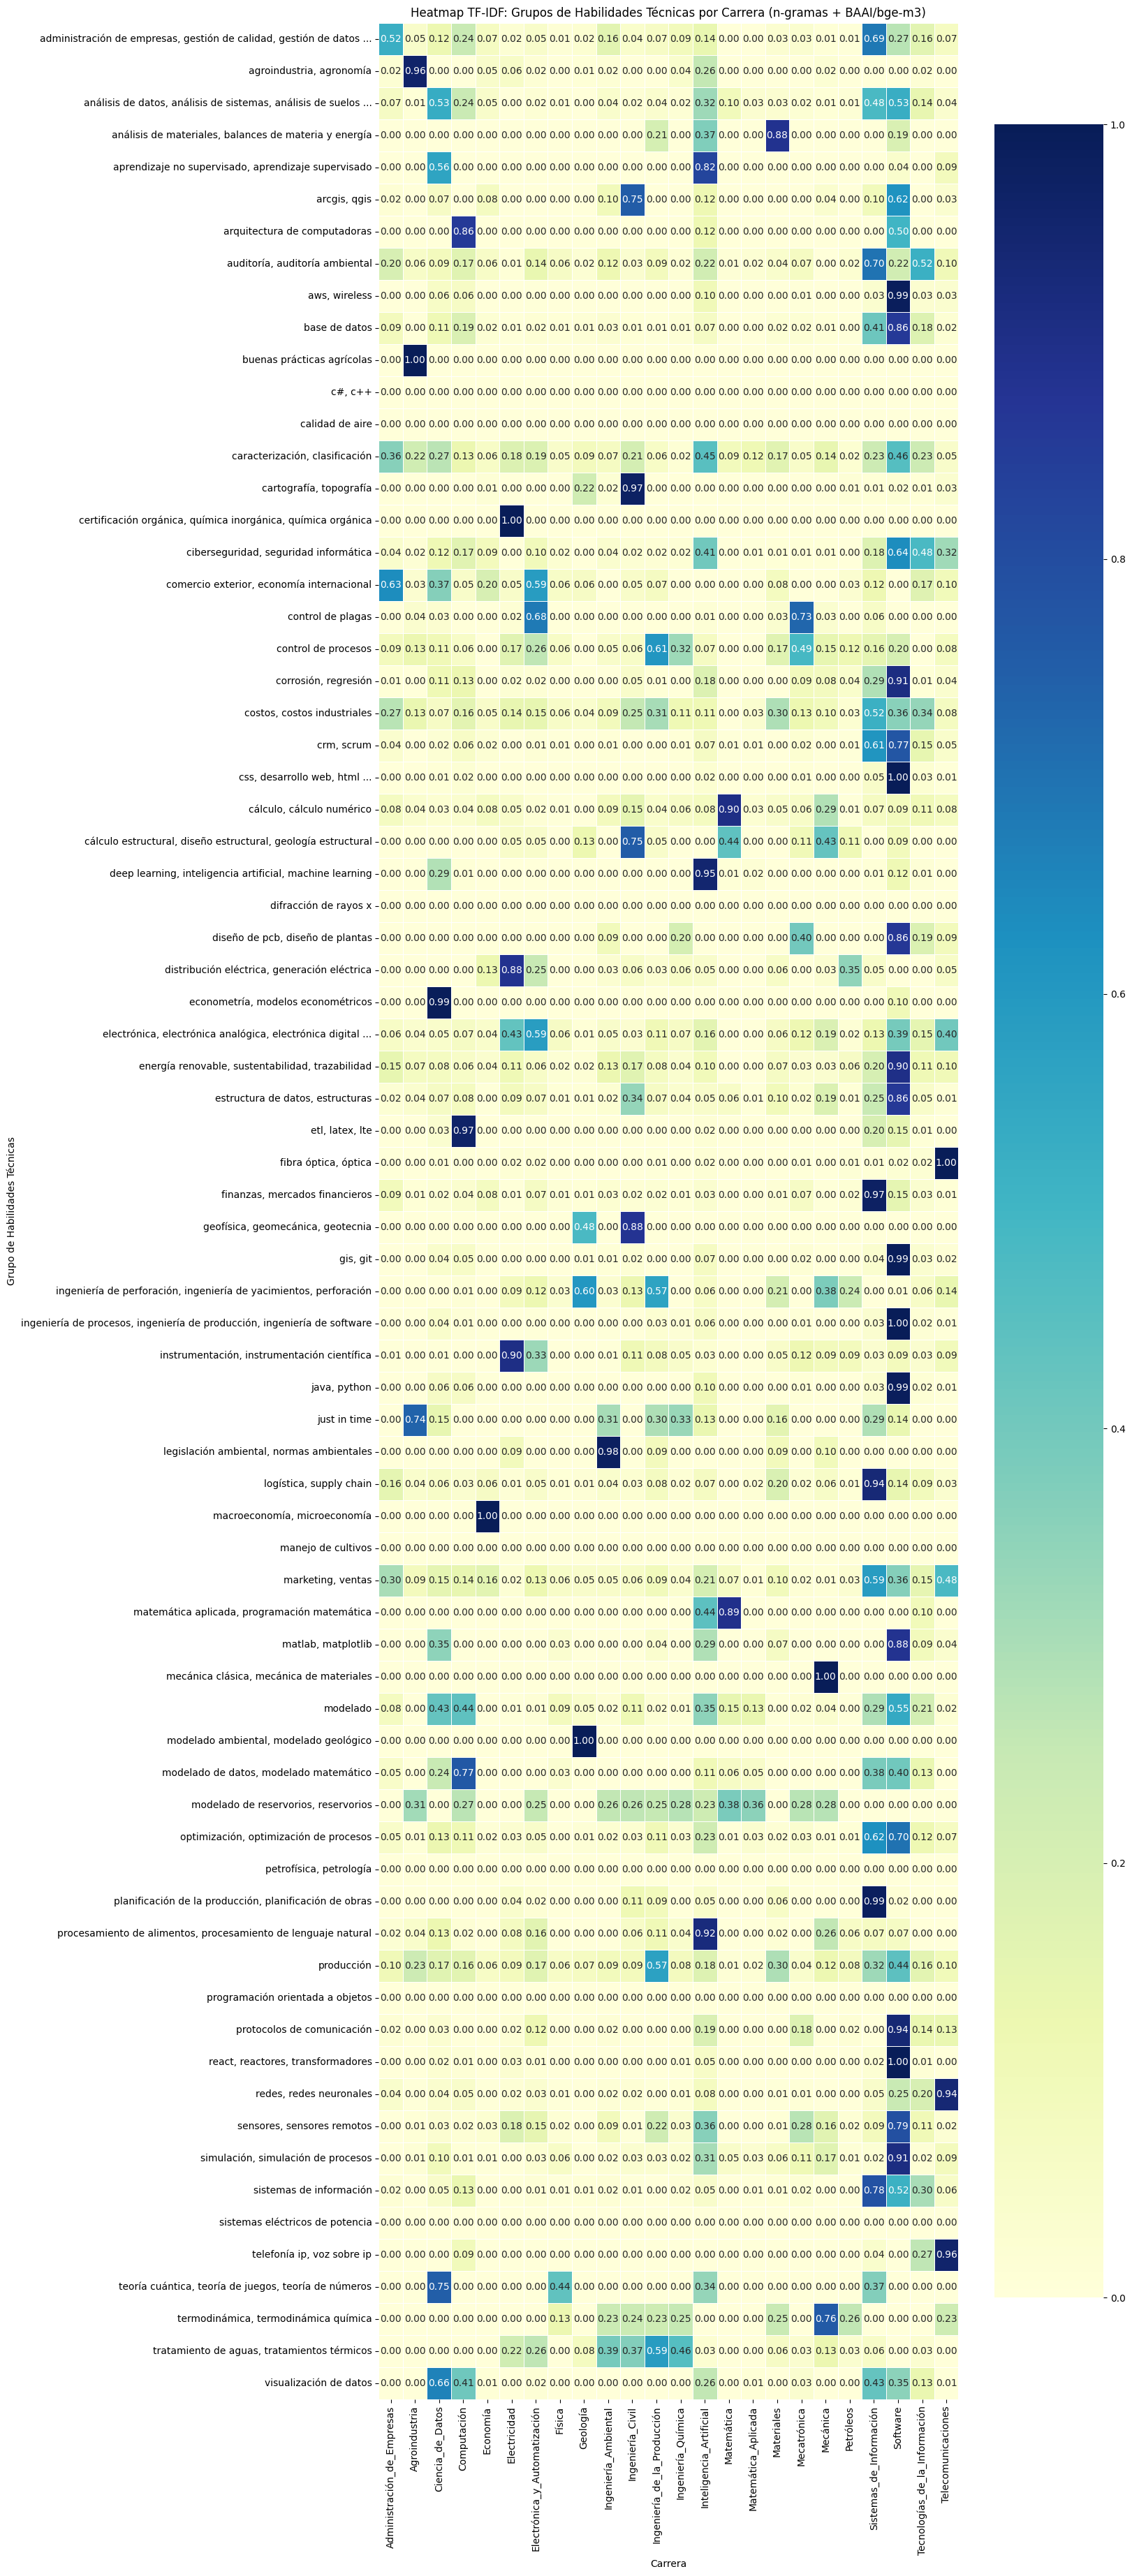

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizar heatmap de la matriz TF-IDF de grupos de habilidades técnicas
plt.figure(figsize=(16, max(6, len(tfidf_emb_df)*0.5)))
sns.heatmap(tfidf_emb_df, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap TF-IDF: Grupos de Habilidades Técnicas por Carrera (n-gramas + BAAI/bge-m3)')
plt.xlabel('Carrera')
plt.ylabel('Grupo de Habilidades Técnicas')
plt.tight_layout()
plt.show()

### Heatmap TF-IDF sin las carreras de Software y Sistemas de la Información
En este heatmap se excluyen las columnas correspondientes a las carreras 'Software' y 'Sistemas_de_Información' para reducir el ruido visual y facilitar la interpretación de los patrones en el resto de las carreras.

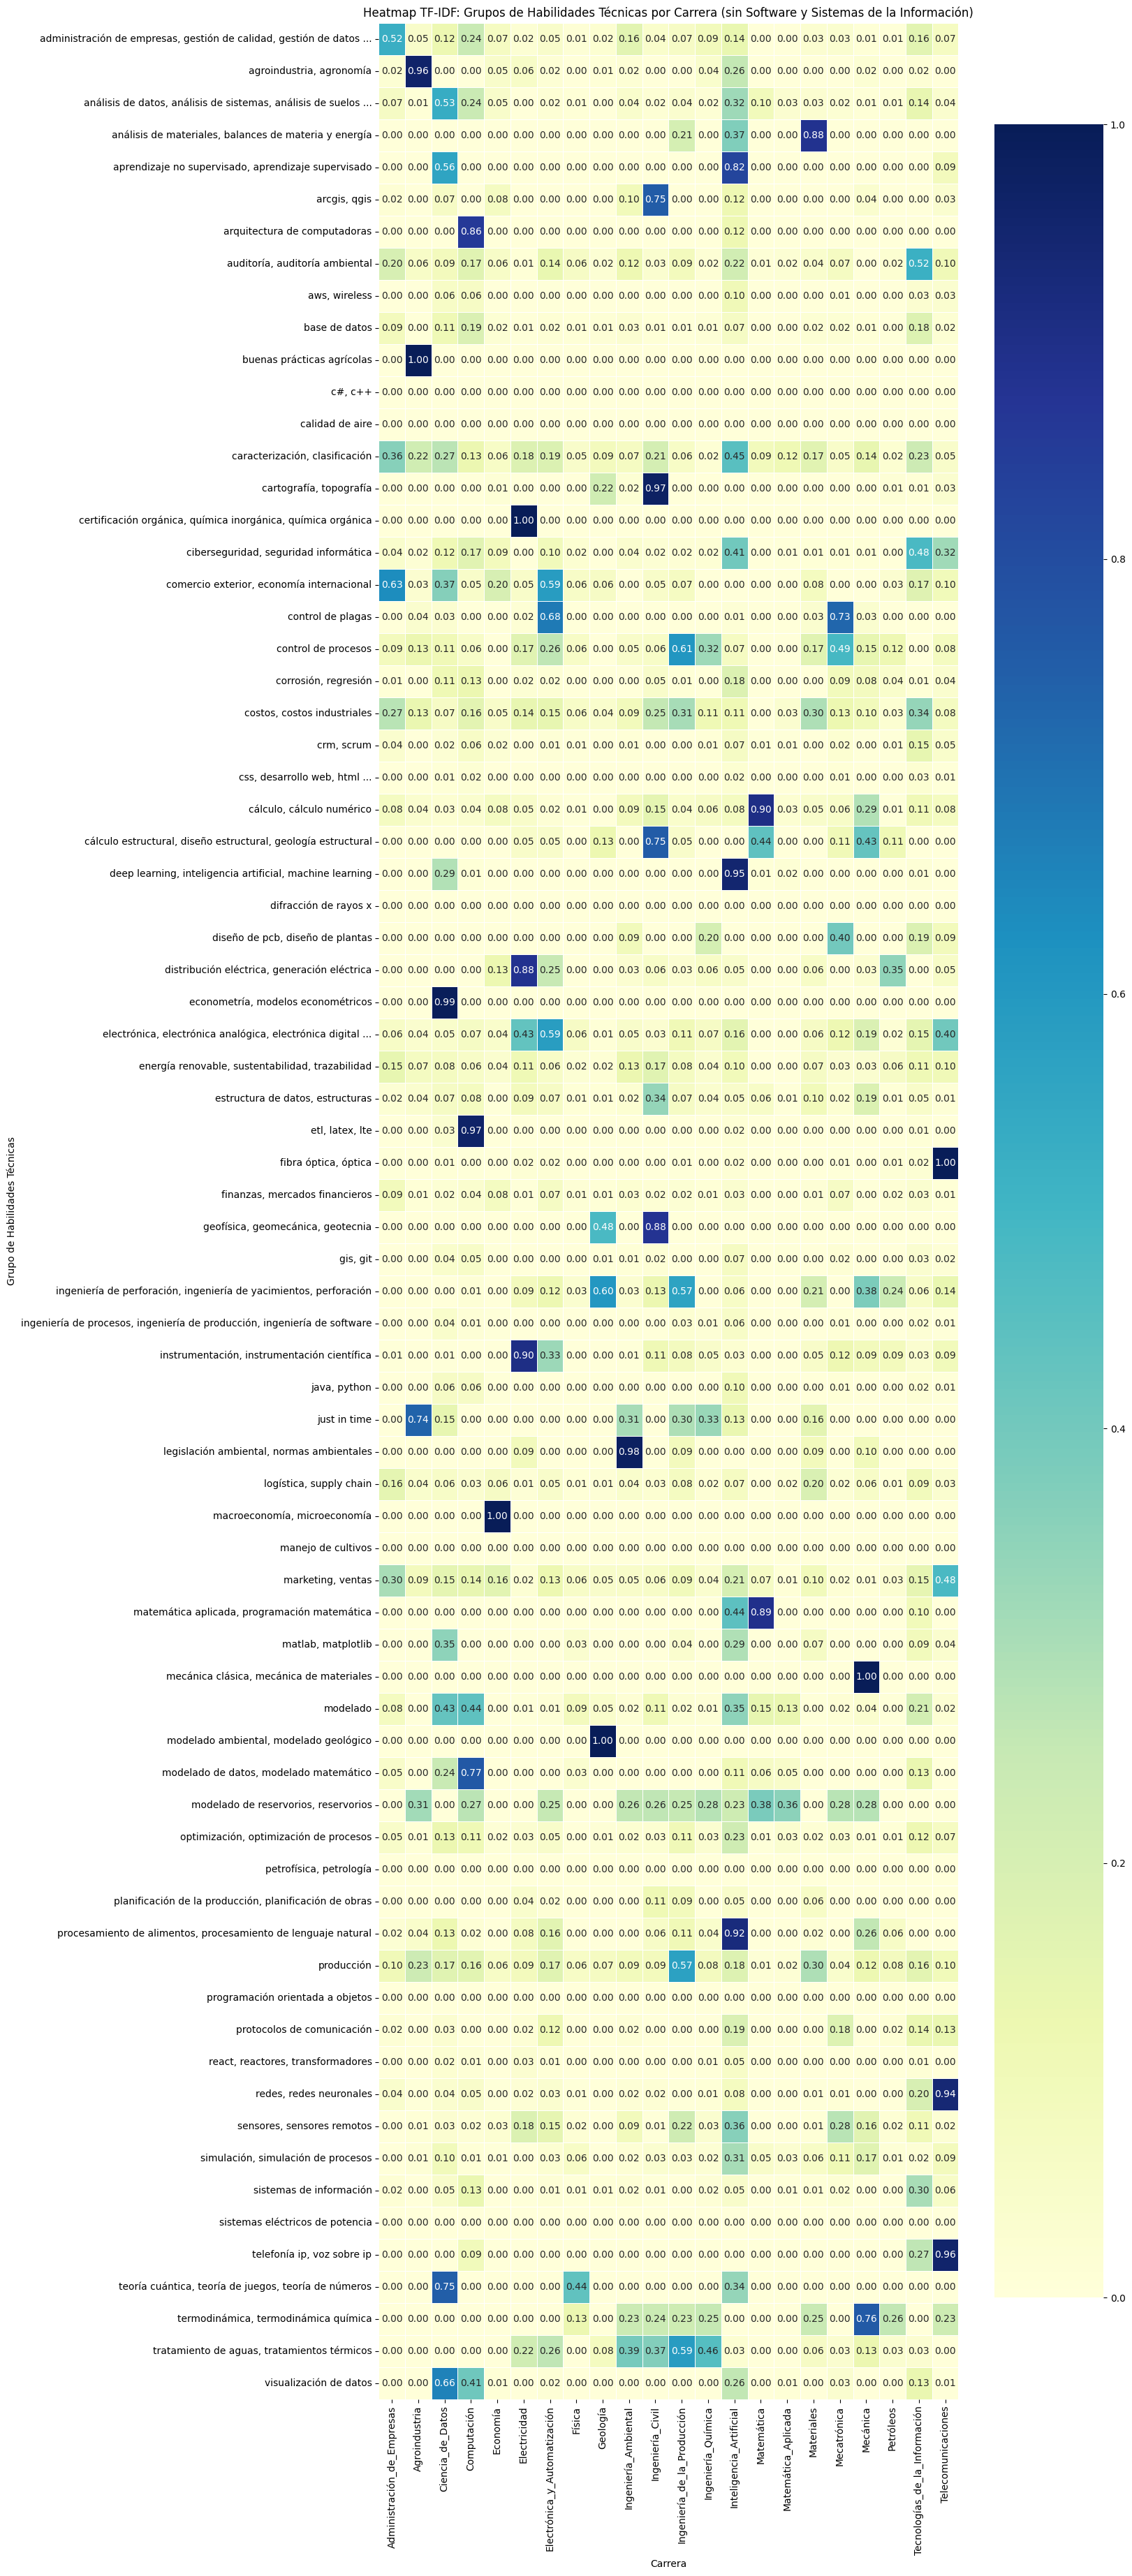

In [17]:
# Crear una copia de la matriz TF-IDF excluyendo las columnas de 'Software' y 'Sistemas_de_Información'
columnas_filtrar = [col for col in tfidf_emb_df.columns if col.lower() not in ['software', 'sistemas_de_información', 'sistemas de información']]
tfidf_filtrado = tfidf_emb_df[columnas_filtrar]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, max(6, len(tfidf_filtrado)*0.5)))
sns.heatmap(tfidf_filtrado, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap TF-IDF: Grupos de Habilidades Técnicas por Carrera (sin Software y Sistemas de la Información)')
plt.xlabel('Carrera')
plt.ylabel('Grupo de Habilidades Técnicas')
plt.tight_layout()
plt.show()